Install required dependencies

In [1]:
!pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow statsmodels

Import required libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

Load datasets

In [4]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('final.csv')
gani_df = pd.read_csv('gani.csv')

print(df.head())
print(gani_df.head())


Saving final.csv to final.csv
Saving gani.csv to gani.csv
         date      time  season  temperature   humidity  solar  wind speed  \
0  2023-01-01  00:00:00  winter    13.901734  65.499998    0.0    7.553054   
1  2023-01-01  01:00:00  winter    11.340819  47.438101    0.0    2.177358   
2  2023-01-01  02:00:00  winter    13.371371  64.068944    0.0    9.131008   
3  2023-01-01  03:00:00  winter    14.260086  54.956177    0.0    2.415330   
4  2023-01-01  04:00:00  winter    10.156370  59.483901    0.0    6.779265   

         delhi  holiday  
0  5980.067673        0  
1  5076.498387        0  
2  6267.645000        0  
3  6525.088204        0  
4  5910.682800        0  
         date      time  season  temperature   humidity  solar  wind speed  \
0  2024-01-02  00:00:00  winter    15.387675  51.289257    0.0    4.029929   
1  2024-01-02  01:00:00  winter    19.678124  64.798428    0.0    2.557387   
2  2024-01-02  02:00:00  winter    15.505050  49.515969    0.0    5.094352   
3  20

Preprocessing for training dataset

In [6]:
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.sort_values(by='datetime', inplace=True)
df.drop(['date', 'time'], axis=1, inplace=True)
df.fillna(method='ffill', inplace=True)

<ipython-input-6-23a3e28cbf83>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Adding time-based features

In [7]:
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['quarter'] = df['datetime'].dt.minute // 15

Adding cyclic features, lag features and smooth target variables

In [8]:

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df['delhi_lag_1'] = df['delhi'].shift(1).fillna(method='bfill')
df['delhi_lag_2'] = df['delhi'].shift(2).fillna(method='bfill')

df['delhi_smoothed'] = df['delhi'].rolling(window=4).mean().fillna(df['delhi'])

<ipython-input-8-83022520f46f>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['delhi_lag_1'] = df['delhi'].shift(1).fillna(method='bfill')
<ipython-input-8-83022520f46f>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['delhi_lag_2'] = df['delhi'].shift(2).fillna(method='bfill')


Define features and target for Train-test split

In [9]:
features = ['temperature', 'humidity', 'wind speed', 'solar', 'holiday',
            'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
            'delhi_lag_1', 'delhi_lag_2', 'quarter']

X = df[features].values
y = df['delhi_smoothed'].values

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

Predictions with RandomForestRegressor


In [10]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

Predictions with LSTM


In [11]:
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
lstm_pred = lstm_model.predict(X_test_lstm).flatten()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


Predictions with ARIMA


In [12]:
arima_model = ARIMA(y_train, order=(5, 1, 0))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=len(y_test))

Evaluation


In [13]:
def evaluate_model(y_test, predictions, model_name):
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"{model_name} - MAE: {mae}, RMSE: {rmse}")

evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, lstm_pred, "LSTM")
evaluate_model(y_test, arima_pred, "ARIMA")

Random Forest - MAE: 262.67187716931124, RMSE: 327.92816095200567
LSTM - MAE: 2975.6747988927727, RMSE: 3081.6664958870965
ARIMA - MAE: 789.3525708223117, RMSE: 988.3574450994522


Visualization


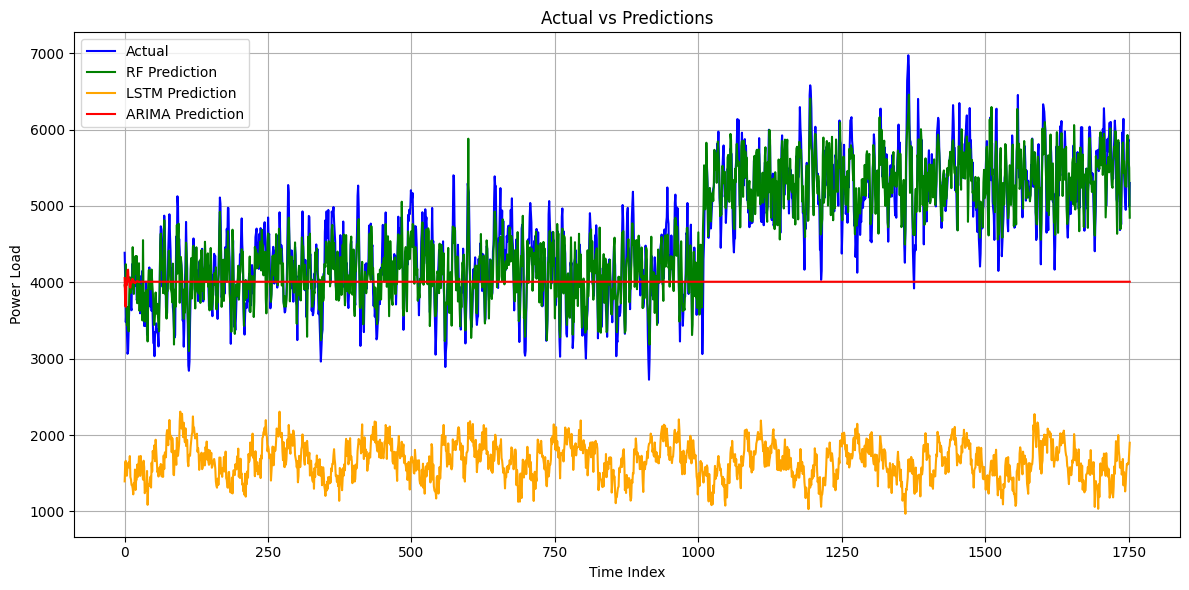

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(rf_pred, label='RF Prediction', color='green')
plt.plot(lstm_pred, label='LSTM Prediction', color='orange')
plt.plot(arima_pred, label='ARIMA Prediction', color='red')
plt.legend()
plt.title('Actual vs Predictions')
plt.xlabel('Time Index')
plt.ylabel('Power Load')
plt.grid(True)
plt.tight_layout()
plt.show()

FOR PREDICTIONS ON TESTING DATASET

In [15]:
gani_path = 'gani.csv'
gani_df = pd.read_csv(gani_path)

Preprocessing for testing dataset

In [32]:
 gani_df['datetime'] = pd.to_datetime(gani_df['datetime'])
gani_df.sort_values(by='datetime', inplace=True)
gani_df.fillna(method='ffill', inplace=True)

<ipython-input-32-1568e0a35bd6>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gani_df.fillna(method='ffill', inplace=True)


Adding time-based features

In [21]:
gani_df['hour'] = gani_df['datetime'].dt.hour
gani_df['dayofweek'] = gani_df['datetime'].dt.dayofweek
gani_df['month'] = gani_df['datetime'].dt.month
gani_df['quarter'] = gani_df['datetime'].dt.minute // 15

Adding cyclic features, lag features and feature scaling


In [22]:
gani_df['hour_sin'] = np.sin(2 * np.pi * gani_df['hour'] / 24)
gani_df['hour_cos'] = np.cos(2 * np.pi * gani_df['hour'] / 24)
gani_df['dayofweek_sin'] = np.sin(2 * np.pi * gani_df['dayofweek'] / 7)
gani_df['dayofweek_cos'] = np.cos(2 * np.pi * gani_df['dayofweek'] / 7)

gani_df['delhi_lag_1'] = df['delhi'].shift(1).fillna(method='bfill')
gani_df['delhi_lag_2'] = df['delhi'].shift(2).fillna(method='bfill')

gani_features = gani_df[features].values
gani_features_scaled = scaler_X.transform(gani_features)

<ipython-input-22-e5ec4cce2d23>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gani_df['delhi_lag_1'] = df['delhi'].shift(1).fillna(method='bfill')
<ipython-input-22-e5ec4cce2d23>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gani_df['delhi_lag_2'] = df['delhi'].shift(2).fillna(method='bfill')


Predictions with Random Forest

In [23]:
rf_pred_gani = rf_model.predict(gani_features_scaled)

Predictions with LSTM

In [24]:
gani_features_lstm = gani_features_scaled.reshape((gani_features_scaled.shape[0], 1, gani_features_scaled.shape[1]))
lstm_pred_gani = lstm_model.predict(gani_features_lstm).flatten()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Predictions with ARIMA


In [25]:
arima_pred_gani = arima_result.forecast(steps=len(gani_df))

Visualize predictions

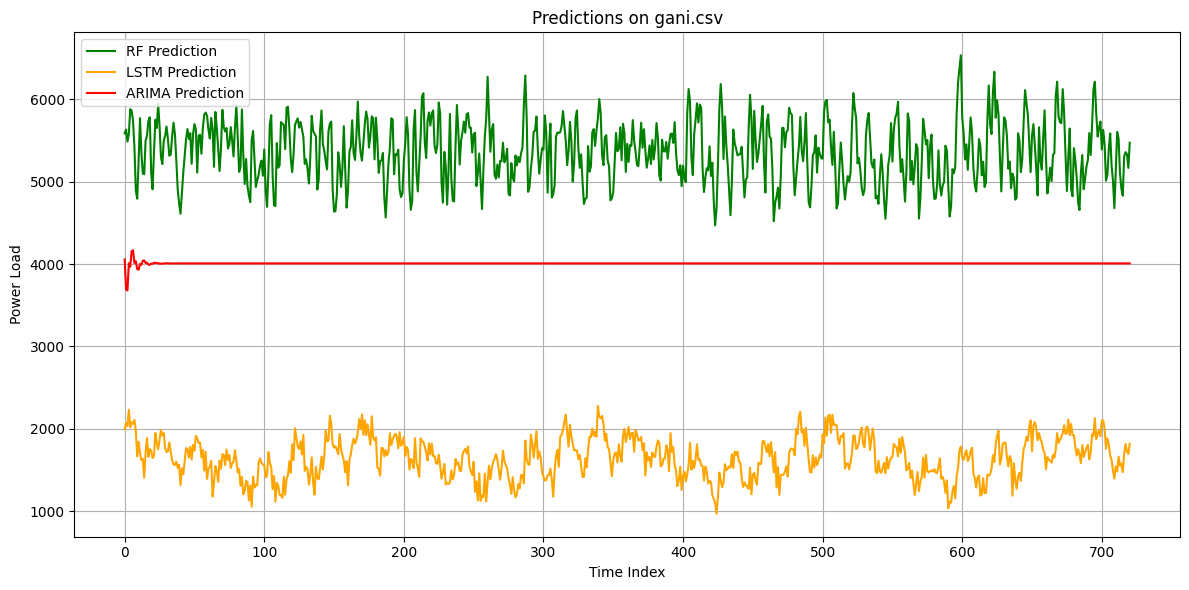

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(rf_pred_gani, label='RF Prediction', color='green')
plt.plot(lstm_pred_gani, label='LSTM Prediction', color='orange')
plt.plot(arima_pred_gani, label='ARIMA Prediction', color='red')
plt.title('Predictions on gani.csv')
plt.xlabel('Time Index')
plt.ylabel('Power Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Save predictions to new file

In [27]:
gani_df['RF_Prediction'] = rf_pred_gani
gani_df['LSTM_Prediction'] = lstm_pred_gani
gani_df['ARIMA_Prediction'] = arima_pred_gani

gani_df.to_csv('gani_predictions.csv', index=False)
print("Predictions saved to gani_predictions.csv")

Predictions saved to gani_predictions.csv
